Spectrogram code extracted from: https://github.com/vijay033/Noise-Suppression-Auto-Encoder/blob/master/ProcessWav.ipynb

In [1]:
# TensorFlow Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, Cropping2D, ZeroPadding2D
from keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

# Other
import os
import glob
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import wavfile
from IPython.display import Audio

## Spectrogram Functions

In [2]:
def amplifyMagnitudeByLog(d):
    return 188.301 * math.log10(d + 1)

def weakenAmplifiedMagnitude(d):
    return math.pow(10, d/188.301)-1

def recoverLinearScale(rgbArray, magnitudeMin, magnitudeMax, phaseMin, phaseMax):
    width = rgbArray.shape[1]
    height = rgbArray.shape[0]
    # print(phaseMax,phaseMin)
    magnitudeVals = rgbArray[:,:,0].astype(float) + rgbArray[:,:,1].astype(float)
    phaseVals = rgbArray[:,:,2].astype(float)
    phaseRange = phaseMax - phaseMin
    magnitudeRange = magnitudeMax - magnitudeMin
    
    for w in range(width):
        for h in range(height):
            phaseVals[h,w] = (phaseVals[h,w] / 255 * phaseRange) + phaseMin
            magnitudeVals[h,w] = weakenAmplifiedMagnitude(magnitudeVals[h,w])
            magnitudeVals[h,w] = (magnitudeVals[h,w] / (255*2) * magnitudeRange) + magnitudeMin
    return magnitudeVals, phaseVals

def recoverSignalFromSpectrogram(numpyarray):
    data = np.array(numpyarray, dtype='uint8')
    width = data.shape[1]
    height = data.shape[0]

    magnitudeVals, phaseVals = recoverLinearScale(data, magnitudeMin, magnitudeMax, phaseMin, phaseMax)
        
    recovered = np.zeros(WINDOW_LENGTH * width // 2 + WINDOW_STEP, dtype=np.int16)
    recovered = np.array(recovered,dtype=np.int16)
    
    for w in range(width):
        toInverse = np.zeros(height, dtype=np.complex_)
        for h in range(height):
            magnitude = magnitudeVals[height-h-1,w]
            phase = phaseVals[height-h-1,w]
            toInverse[h] = magnitude * math.cos(phase) + (1j * magnitude * math.sin(phase))
        signal = np.fft.irfft(toInverse)
        recovered[w*WINDOW_STEP:w*WINDOW_STEP + WINDOW_LENGTH] += signal[:WINDOW_LENGTH].astype(np.int16)
    return recovered


# Use these initializations for recovery from spectrogram
FFT_LENGTH = 512
WINDOW_LENGTH = 512
WINDOW_STEP = int(WINDOW_LENGTH / 2)
phaseMax = 3.141592653589793 
phaseMin = -3.141592653589793
magnitudeMax = 2211683.973249525
magnitudeMin = 0.0
rate = 16000

## Data Loading

In [3]:
# /data/csc6621/24-team-c/dataset/
files_train = glob.glob("LibriNoise_Train_Test_NPY/mat_train/*.npy")
files_train_y = glob.glob("LibriNoise_Train_Test_NPY/mat_ytrain/*.npy")
files_test = glob.glob("LibriNoise_Train_Test_NPY/mat_test/*.npy")
files_test_y = glob.glob("LibriNoise_Train_Test_NPY/mat_ytest/*.npy")

In [4]:
class SpectrogramDataGenerator(keras.utils.Sequence):
    def __init__(self, X_paths, y_paths, batch_size):
        self.X_paths = X_paths
        self.y_paths = y_paths
        self.batch_size = batch_size
        self.indices = np.arange(len(self.X_paths))

    def __len__(self):
        return int(np.ceil(len(self.X_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]
        X_batch = []
        y_batch = []
        for i in batch_indices:
            X_batch.append(np.load(self.X_paths[i])/255)
            y_batch.append(np.load(self.y_paths[i])/255)
        return np.array(X_batch), np.array(y_batch)

In [5]:
data = SpectrogramDataGenerator(files_train, files_train_y, batch_size=32)

## Models

In [6]:
K.clear_session()
INPUT_DIM = (257, 62, 3)

## U-Net Large

In [31]:
def unet(input_size):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    padded1 = ZeroPadding2D(padding=((0, 0), (0, 1)))(pool1) # Deal with odd dimensions
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(padded1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    
    # Decoder
    up6 = Conv2DTranspose(512, 2, strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    crop_conv4 = Cropping2D(cropping=((0, 0), (0, 0)))(conv4)
    merge6 = concatenate([crop_conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2DTranspose(256, 2, strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    crop_conv3 = Cropping2D(cropping=((0, 0), (0, 0)))(conv3)
    merge7 = concatenate([crop_conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2DTranspose(128, 2, strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    crop_conv2 = Cropping2D(cropping=((0, 0), (0, 0)))(conv2)
    merge8 = concatenate([crop_conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2DTranspose(64, 2, strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    crop_up9 = Cropping2D(cropping=((0, 0), (0, 2)))(up9)
    pad_up9 = ZeroPadding2D(padding=((1, 0), (0, 0)))(crop_up9)
    merge9 = concatenate([conv1, pad_up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    # Output
    conv10 = Conv2D(3, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=conv10)
    
    return model

In [39]:
un = unet(input_size=INPUT_DIM)
#opt = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
#reduce_lr = ReduceLROnPlateau(patience=3, monitor='loss', min_delta=0.0002)
un.compile(optimizer='adam', loss='mean_squared_error')
un.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 257, 62, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 257, 62, 64)  1792        ['input_2[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 257, 62, 64)  36928       ['conv2d_11[0][0]']              
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 128, 31, 64)  0          ['conv2d_12[0][0]']        

 zero_padding2d_3 (ZeroPadding2  (None, 257, 62, 64)  0          ['cropping2d_4[0][0]']           
 D)                                                                                               
                                                                                                  
 concatenate_5 (Concatenate)    (None, 257, 62, 128  0           ['conv2d_12[0][0]',              
                                )                                 'zero_padding2d_3[0][0]']       
                                                                                                  
 conv2d_27 (Conv2D)             (None, 257, 62, 64)  73792       ['concatenate_5[0][0]']          
                                                                                                  
 conv2d_28 (Conv2D)             (None, 257, 62, 64)  36928       ['conv2d_27[0][0]']              
                                                                                                  
 conv2d_29

In [40]:
history = un.fit(data,
                 epochs=50,
                 callbacks=[reduce_lr])

Epoch 1/50
219/219 [==============================] - 44s 199ms/step - loss: 0.0299 - lr: 0.0010
Epoch 2/50
219/219 [==============================] - 45s 206ms/step - loss: 0.0262 - lr: 0.0010
Epoch 3/50
219/219 [==============================] - 45s 206ms/step - loss: 0.0251 - lr: 0.0010
Epoch 4/50
219/219 [==============================] - 45s 206ms/step - loss: 0.0243 - lr: 0.0010
Epoch 5/50
219/219 [==============================] - 45s 203ms/step - loss: 0.0237 - lr: 0.0010
Epoch 6/50
219/219 [==============================] - 45s 204ms/step - loss: 0.0232 - lr: 0.0010
Epoch 7/50
219/219 [==============================] - 45s 204ms/step - loss: 0.0228 - lr: 0.0010
Epoch 8/50
219/219 [==============================] - 45s 204ms/step - loss: 0.0224 - lr: 0.0010
Epoch 9/50
219/219 [==============================] - 45s 204ms/step - loss: 0.0221 - lr: 0.0010
Epoch 10/50
219/219 [==============================] - 44s 203ms/step - loss: 0.0221 - lr: 0.0010
Epoch 11/50
219/219 [========

## U-Net Small

In [83]:
def unet_small(input_size):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    padded1 = ZeroPadding2D(padding=((0, 0), (0, 1)))(pool1) # Deal with odd dimensions
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(padded1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    
    # Decoder
    up1 = Conv2DTranspose(128, 2, strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    merge1 = concatenate([conv2, up1], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    
    up2 = Conv2DTranspose(64, 2, strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    crop_up2 = Cropping2D(cropping=((0, 0), (0, 2)))(up2)
    pad_up2 = ZeroPadding2D(padding=((1, 0), (0, 0)))(crop_up2) # Deal with odd dimensions
    merge2 = concatenate([conv1, pad_up2], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge2)
    conv5 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    
    # Output
    conv6 = Conv2D(3, 1, activation='sigmoid')(conv5)
    
    model = Model(inputs=inputs, outputs=conv6)
    
    return model

In [84]:
un_small = unet_small(INPUT_DIM)
un_small.compile(optimizer=RMSprop(), loss='mean_squared_error')
un_small.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 257, 62, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 257, 62, 64)  1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 257, 62, 64)  36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 31, 64)  0           ['conv2d_1[0][0]']           

In [85]:
reduce_lr = ReduceLROnPlateau(patience=3, monitor='loss', min_delta=0.0003)
history = un_small.fit(data,
                       epochs=30, 
                       callbacks=[reduce_lr])

Epoch 1/30
219/219 [==============================] - 31s 139ms/step - loss: 0.0344 - lr: 0.0010
Epoch 2/30
219/219 [==============================] - 30s 135ms/step - loss: 0.0266 - lr: 0.0010
Epoch 3/30
219/219 [==============================] - 31s 141ms/step - loss: 0.0253 - lr: 0.0010
Epoch 4/30
219/219 [==============================] - 30s 137ms/step - loss: 0.0245 - lr: 0.0010
Epoch 5/30
219/219 [==============================] - 30s 138ms/step - loss: 0.0240 - lr: 0.0010
Epoch 6/30
219/219 [==============================] - 30s 136ms/step - loss: 0.0237 - lr: 0.0010
Epoch 7/30
219/219 [==============================] - 30s 137ms/step - loss: 0.0232 - lr: 0.0010
Epoch 8/30
219/219 [==============================] - 30s 138ms/step - loss: 0.0230 - lr: 0.0010
Epoch 9/30
219/219 [==============================] - 31s 140ms/step - loss: 0.0227 - lr: 0.0010
Epoch 10/30
219/219 [==============================] - 30s 136ms/step - loss: 0.0225 - lr: 0.0010
Epoch 11/30
219/219 [========

In [88]:
#un_small.save('unet-small-30epoch-rmsprop3.keras')

In [66]:
#un_small = keras.models.load_model('unet-small-30epoch-rmsprop1.keras')

| Model Size          | Epochs | Optimizer              | Train Spectrogram MSE | Test Signal SNR |
|---------------------|--------|------------------------|-----------------------|-----------------|
| Large (31m params)  | 20     | Adam                   | 0.0208                | 61/44           |
| -                   | 30     | -                      | 0.0196                |                 |
| -                   | 50     | Adam + LR Reduction    | 0.0193                | 69/36           |
| -                   | 20     | RMSProp                | 0.1241                |                 |
| Small (1.8m params) | 10     | Adam                   | 0.0233                | 47/58           |
| -                   | 20     | -                      | 0.0213                |                 |
| -                   | 30     | Adam + LR Reduction    | 0.0219                |                 |
| -                   | 50     | -                      | 0.0219                |                 |
| -                   | 30     | RMSProp + LR Reduction | 0.0202                | 68/37           |

## View Output

In [8]:
test_data = SpectrogramDataGenerator(files_test, files_test_y, batch_size=1)

1/1 [==============================] - 0s 15ms/step


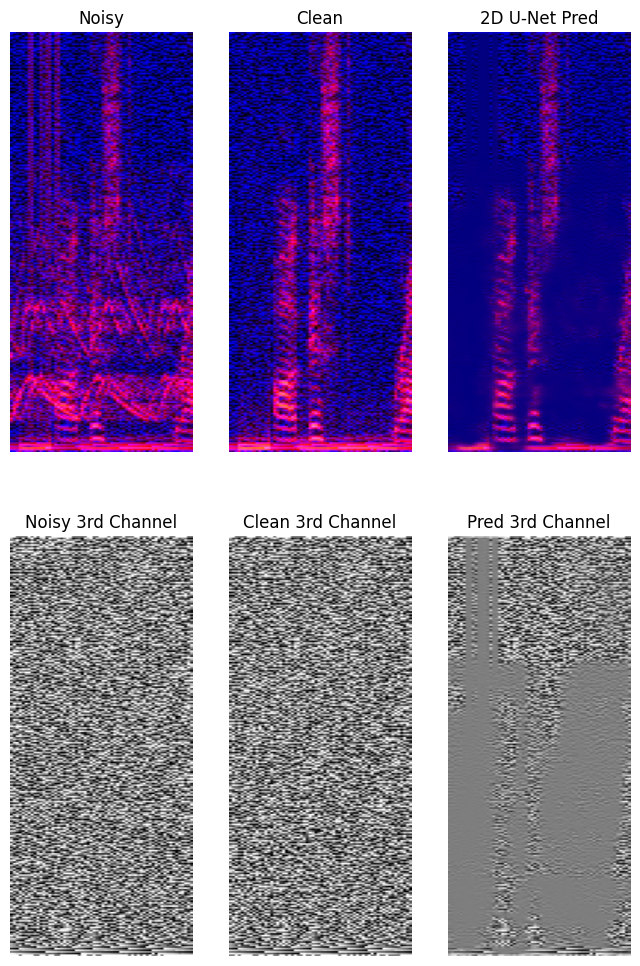

LibriNoise_Train_Test_NPY/mat_test\4088-158079-0000.npy


In [172]:
n = 53
X_test, y_test = test_data[n]
pred = un_small.predict(X_test)

fig, axes = plt.subplots(2, 3, figsize=(8,12))
axes[0][0].imshow(X_test[0], aspect='auto')
axes[0][0].set_axis_off()
axes[0][0].set_title('Noisy')
axes[0][1].imshow(y_test[0], aspect='auto')
axes[0][1].set_axis_off()
axes[0][1].set_title('Clean')
axes[0][2].imshow(pred[0], aspect='auto')
axes[0][2].set_axis_off()
axes[0][2].set_title('2D U-Net Pred')

axes[1][0].imshow(X_test[0][:,:,-1], aspect='auto', cmap='gray')
axes[1][0].set_axis_off()
axes[1][0].set_title('Noisy 3rd Channel')
axes[1][1].imshow(y_test[0][:,:,-1], aspect='auto', cmap='gray')
axes[1][1].set_axis_off()
axes[1][1].set_title('Clean 3rd Channel')
axes[1][2].imshow(pred[0][:,:,-1], aspect='auto', cmap='gray')
axes[1][2].set_axis_off()
axes[1][2].set_title('Pred 3rd Channel')
plt.show()

print(files_test[n])

In [173]:
noisy_wav = recoverSignalFromSpectrogram(X_test[0] * 255)
clean_wav = recoverSignalFromSpectrogram(y_test[0] * 255)
pred_wav = recoverSignalFromSpectrogram(pred[0] * 255)

In [174]:
Audio(data=noisy_wav, rate=rate)

In [175]:
Audio(data=clean_wav, rate=rate)

In [176]:
Audio(data=pred_wav, rate=rate)

## Test Metrics

In [178]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

In [179]:
def calculate_snr(original_signal, denoised_signal):
    # Calculate signal power
    signal_power = np.mean(original_signal**2)
    # Calculate noise
    noise = original_signal - denoised_signal
    # Calculate noise power
    noise_power = np.mean(noise**2)
    # Calculate SNR in dB
    snr_db = 10 * np.log10(signal_power / noise_power)

    return snr_db

In [180]:
un_small = keras.models.load_model('U-Net Small Results RMSprop/unet-small-30epoch-rmsprop1.keras')

In [191]:
mses = []
maes = []
snrs_input = []
snrs_output = []

test_data = SpectrogramDataGenerator(files_test, files_test_y, batch_size=1)
pred = un_small.predict(test_data)
for idx, spectrogram in tqdm(enumerate(pred), total=pred.shape[0]):
    
    # Ignoring prediction 3rd channel, replacing with noisy 3rd channel
    spectrogram[:,:,-1] = test_data[idx][0][0,:,:,-1]
    
    noisy_signal = recoverSignalFromSpectrogram(test_data[idx][0][0] * 255).astype('int32')
    true_clean_signal = recoverSignalFromSpectrogram(test_data[idx][1][0] * 255).astype('int32')
    denoised_signal = recoverSignalFromSpectrogram(spectrogram * 255).astype('int32')

    mses.append(mean_squared_error(true_clean_signal, denoised_signal))
    maes.append(mean_absolute_error(true_clean_signal, denoised_signal))
    
    snrs_input.append(calculate_snr(true_clean_signal, noisy_signal))
    snrs_output.append(calculate_snr(true_clean_signal, denoised_signal))

105/105 [==============================] - 1s 6ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:13<00:00,  7.98it/s]


In [192]:
better = 0
worse = 0
for i, pair in enumerate(zip(snrs_input, snrs_output)):
    if pair[0] > pair[1]:
        worse +=1
    else:
        better +=1
better, worse

(78, 27)

In [187]:
# From 3 training runs
mse_all = [2343481.223685516, 2378067.4839988425,2331832.866954247]
mae_all = [830.8231339758127, 834.576952829743, 826.650562759826]

In [188]:
np.mean(mse_all), np.std(mse_all)

(2351127.1915462017, 19634.248507986944)

In [189]:
np.mean(mae_all), np.std(mae_all)

(830.6835498551272, 3.2374401080875073)